<a href="https://colab.research.google.com/github/strongway/tutorial_data_science/blob/master/RT_analysis_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reaction time (RT) analyses with Python

**Dr. Zhuanghua Shi, 2021**

This tutorial serves as hands-on for the lecture "Psychophysics" on how to do basic analysis on RTs. 


In [ ]:
# install satistical package pingouin
!pip install pingouin

In [2]:
# Some prep work to get the data from R and into pandas
%matplotlib inline

# pandas for data process, seaborn for plotting, in addition, matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

pd.set_option("display.max_rows", 15)

## 1. Import data to Colab Cloud (Optional)

Colab provides cloud computing and collaboration with python notebook, but not natively for data sharing. Fortunately, there are several ways for sharing data. 



### Uploading files from your local file system

You share the data using other cloud methods, and then upload files locally. `files.upload` returns a dictionary of the files which were uploaded.
The dictionary is keyed by the file name, the value is the data which was uploaded.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Another example, upload a csv file and import as pandas table.



In [ ]:
import io
from google.colab import files

uploaded = files.upload()
key, value = uploaded.popitem()
df = pd.read_csv(io.BytesIO(value))
df.head()

### Downloading files to your local file system

`files.download` will invoke a browser download of the file to the user's local computer.


In [ ]:
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

### Mounting Google Drive locally

The example below shows how to mount your Google Drive in your virtual machine using an authorization code, and shows a couple of ways to write & read files there. Once executed, observe the new file (`foo.txt`) is visible in https://drive.google.com/

Note this only supports reading and writing files; to programmatically change sharing settings etc use one of the other options below.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### Using internet URL

If you store your data in some public available address, you can simply use URL to read in. 

In [ ]:
url = 'https://raw.githubusercontent.com/msenselab/dynamic_search/master/data/exp1.csv'
dat = pd.read_csv(url)
dat.head()

## 2. Pandas Data Table Basic

read and explore pandas data table. 

### Shape, list rows

In [ ]:
dat.shape  # <--- The python code

To view the data, use `.head()` or `.tail()` function

In [ ]:
dat.tail()

__Your task:__ Please list the first 10 rows of the data. 

In [ ]:
# your code here:

### __Solution__:

In [ ]:
dat.head(10)

### Statistical summary

In [ ]:
# show some descriptive summary
# summary(dat)
dat.describe()

In [ ]:
# show unique of one column
dat.setsize.unique()

In [ ]:
dat['sub'].unique()

In [ ]:
type(dat.resp)

### Indexing, slicing and subsetting in Pandas

Indexing, slicing and subsettings are basic data manipulation. For example, we need to select specific subject for further data exploring, or we need to exclude error trials etc. 




#### Doing in matlab way

Pandas is a matrix, so you can index using standard matlab way. 

In [ ]:
# show the first 5 rows
dat[:5]

In [ ]:
# select first 3 rows, first 3 columns
dat.iloc[:3,:3]

In [ ]:
# select target, setsize, and rt
dat.loc[:,['target','setsize','rt']].head()

#### Using query() to filter rows

Pandas `query()` function is powerful for subsecting the data. 

In [ ]:
# select subject 1
dat.query('sub == 1 & correct == 1 & dyn == "Static"')

### Selecting columns using []

In [ ]:
dat[['sub', 'setsize', 'rt']]

In [ ]:
# using columns
dat[dat.columns[1:4]]

### Rename

Similar to `.replace()`, `.rename()` function also copies the data and return a new object. So you need to store it in a new object. 

In [ ]:
ndata = dat.rename(columns={'dyn': 'Display'})
ndata.head()

Pandas is more verbose, but the the argument to `columns` can be any mapping. So it's often used with a function to perform a common task, say `df.rename(columns=lambda x: x.replace('-', '_'))` to replace any dashes with underscores. Also, ``rename`` (the pandas version) can be applied to the Index.

### Add new columns with assign() 

In [ ]:
ndata.assign(rtms=ndata.rt*1000)

In [ ]:
# if you have multiple assign in a chain, you need to explicit to say the dataframe.

ndata.assign(rtms=ndata.rt*1000).assign(inv_rt = lambda df: 1/df.rtms)

### Summarise values with summarise()

In [ ]:
# summarise(ndata,
#   rt = mean(rt, na.rm = TRUE))
ndata.rt.mean()

This is only roughly equivalent.
`summarise` takes a callable (e.g. `mean`, `sum`) and evaluates that on the DataFrame. In pandas these are spread across `pd.DataFrame.mean`, `pd.DataFrame.sum`. This will come up again when we look at `groupby`.

### Grouping, aggregating, and Chaining

Note: Pandas uses `.groupby()` function, but you need to aware that pandas `.groupby()` will **<font color = 'red'>put grouped variables into multi-index</font>**, so the columns after grouping will not include those grouped variables. If you want to put them back **as columns** for later usage, you need to add **`.reset_index()`**. 

Often, we want to calculate simple statistics across different conditions, such as `mean`, `sem`,`std` etc. We can use Pandas `agg()` function to do this. `agg()` accepts 'column_name: stat_function` format for aggregation. You can use multiple dictionary to aggregate multiple functions / columns. 

Using Python class function '.' to chain all operations together. 

In [ ]:
# let's average correct rate for each participants, and visualize it
#ndata.groupby('sub').agg({'correct':np.mean}).plot.bar()

#if you have only one column to aggregate. the following code will do the same
macc = ndata.groupby('sub').correct.mean()#.plot.bar()
print(macc)
macc.plot.bar()

In [ ]:
# now we want to average RTs for correct trials, separate for sub, target, setsize, and display
mrt = ndata.query('correct == 1')\
  .groupby(  ['sub','target','setsize','Display'])\
    .agg({"resp":"count",
         "rt":["mean","sem"]})\
    .rename(columns={"resp":"count"})\
    .reset_index()
mrt.head()

Note, when python chains span over multiple lines, take care the indentation and add one '\' at the previous line. 

I think pandas is more difficult for this particular example.
There isn't as natural a way to mix column-agnostic aggregations (like ``count``) with column-specific aggregations like the other two. You end up writing could like `.agg{'resp': 'count'}` which reads, "I want the count of `resp`", even though you don't care about `resp` specifically. You could just as easily have said `.agg('Cond': 'count')`.
Additionally assigning names can't be done as cleanly in pandas; you have to just follow it up with a ``rename`` like before.

The result is a `MultiIndex` in the columns which can be a bit awkard to work with (you can drop a level with `r.columns.droplevel()`). But `MultiIndex` has its own purpose, such as subsecting data (We will see later on). 

In the above example, if you want to read mean RT, you need to use mrt.rt['mean'], because it is muli-level columns. 

In [ ]:
mrt.rt['mean']

# RT analyses - an example


The example we use is from a visual search study published in 2019:

* Shi, Z., Allenmark, F., Zhu, X., Elliott, M. A., & Müller, H. J. (2019). To quit or not to quit in dynamic search. Attention, Perception & Psychophysics. https://doi.org/10.3758/s13414-019-01857-7

The original data analysis and modelling were done in R. Here we use Python to do similar analysis. 

Explorative data analysis (EDA) often requires you to get familiar with data by various analysis. For RT analyses, usually we do followings:

1. Examining RT distributions (outliers)
2. Estiamte Error rates
3. Mean RTs and relative statistics. 
4. Using SAT transformation

## Read raw data and RT distributions

Import data as we have shown above. 

In [4]:
url = 'https://raw.githubusercontent.com/msenselab/dynamic_search/master/data/exp1.csv'
dat = pd.read_csv(url)
dat.head()

,target,setsize,dyn,resp,rt,sub,exp,correct
0,Absent,12,Static,2,2.583007,1,1,1
1,Absent,8,Static,2,0.935967,1,1,1
2,Present,16,Static,1,0.794771,1,1,1
3,Present,8,Static,1,1.241838,1,1,1
4,Absent,12,Static,2,1.759485,1,1,1


## Explorative data analysis

The first step is to check individual participants' RTs and see if there are any outliers. 

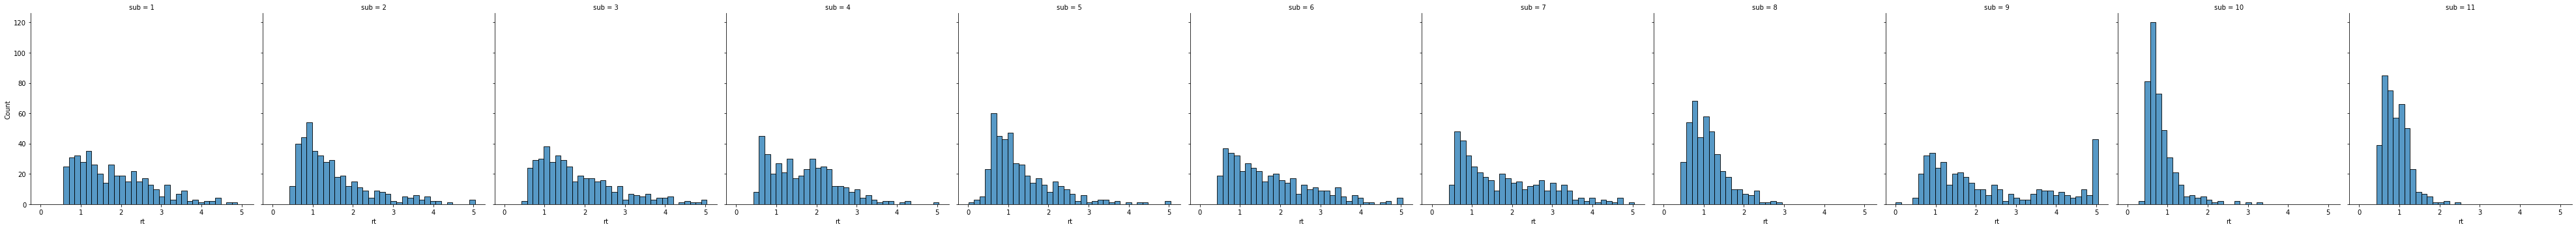

In [12]:
# inpsect individual histogram of RT distribution
sns.displot(data = dat, x = 'rt', col = 'sub')

### Outlier detection
As we can see from the above figures, most of RT distribitions are left skewed. Some may have high peak (e.g., Sub 10.), and suome are relative flat (e.g., Sub 6). One distribution is quite different form the others, that is Sub. 9. This subject has an additional peak at 5 seconds, which in the experiment was 'no response trials. 

There are two ways to treat those 'bad' data:
1. filter out those incorrect and no-response trials, and treat the data as 'normal' data. 
2. If you think this dataset is deviated a lot from the sampled datasets (e.g., using SD as measure), you can mark this as outliers. 

Here this dataset has standard RT distribition, we only need to filter out those error and no response trials. We can use $\bar {RT} \pm n\cdot \sigma $ rule, or use quantile ranges. 

Steps:
1. calculate mean and sigma, quantiles for individual dataset
2. Merge the means to the raw data
3. Filter out the outliers

In [49]:
# Filter the outliers
# we use quantiles to filter out outliers
# 1. create a table with quantiles
subm = dat.query('rt<5 & correct == 1').groupby('sub').rt.agg(
    ['mean','std', 
    ('q01' ,lambda x: np.quantile(a=x, q = 0.01)),
    ('q99' ,lambda x: np.quantile(a=x, q = 0.99)) 
    ]).reset_index()
subm.head(5)

,sub,mean,std,q01,q99
0,1,1.810085,0.918304,0.606547,4.435528
1,2,1.461401,0.832538,0.524191,3.982744
2,3,1.730457,0.896048,0.616167,4.147761
3,4,1.658965,0.807540,0.547726,3.781277
4,5,1.296664,0.713038,0.382460,3.378438


In [50]:
# Step 2. merge the quantiles to the raw data
dat_f = pd.merge(dat, subm, on = 'sub')
dat_f.head()


,target,setsize,dyn,resp,rt,sub,exp,correct,mean,std,q01,q99
0,Absent,12,Static,2,2.583007,1,1,1,1.810085,0.918304,0.606547,4.435528
1,Absent,8,Static,2,0.935967,1,1,1,1.810085,0.918304,0.606547,4.435528
2,Present,16,Static,1,0.794771,1,1,1,1.810085,0.918304,0.606547,4.435528
3,Present,8,Static,1,1.241838,1,1,1,1.810085,0.918304,0.606547,4.435528
4,Absent,12,Static,2,1.759485,1,1,1,1.810085,0.918304,0.606547,4.435528


In [55]:
# Step 3. filter out outliers and drop unnecessary columns
dat_v = dat_f.query('q01 < rt < q99').drop(['mean','std','q01','q99'], axis = 1)
# show the percentage of dropped outliers
print(1-len(dat_v)/len(dat_f))

0.03463203463203468



Now we have valid trials, but still contain those error trials. Let's first check the distribution for experimental conditions. 

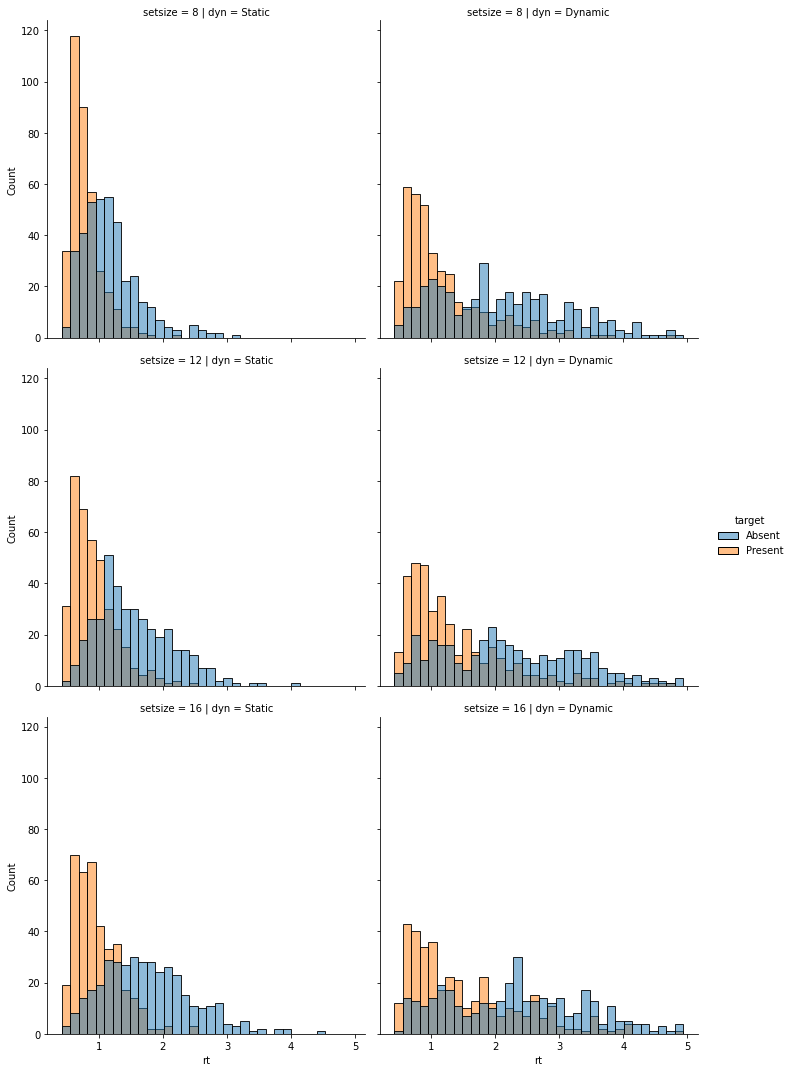

In [59]:
sns.displot(data = dat_v, x='rt', hue = 'target', col = 'dyn',row = 'setsize')

The above histograms showed that the dynamic displays had relative slow and flat RT distributions. Consistently across all displays (set size, display type), the target absent conditions were slower. 

## Error rates

Let's now check the error vs. correct trials. 

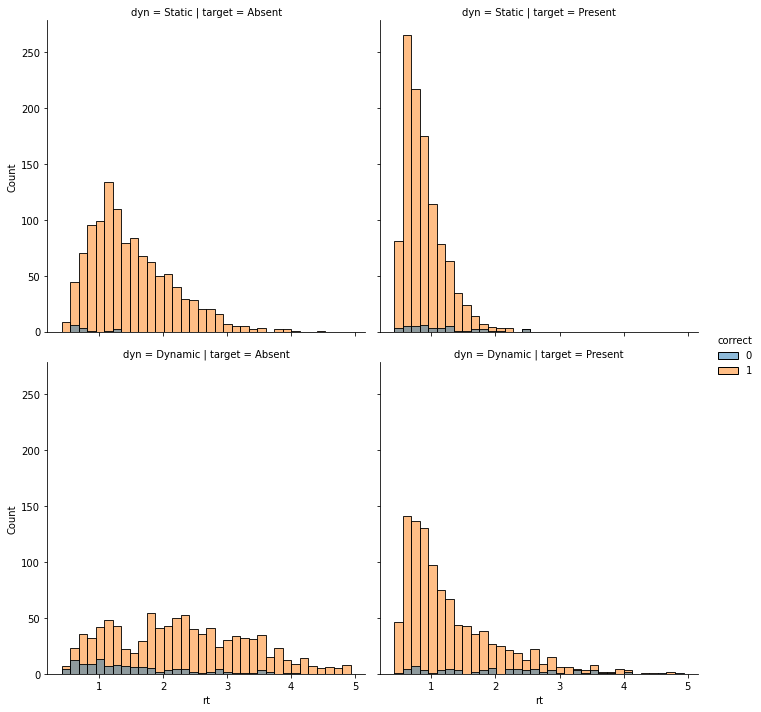

In [60]:
sns.displot(data = dat_v, x = 'rt', hue = 'correct', col = 'target',row = 'dyn')

Note: Error trials did not always slower, rather occurred earlier! The patterns suggest that participants often responded too fast to make blunt errors. 

Having those insightful explorations, we now go for mean RTs and error rates. 

In [65]:
er_rates = dat_v.groupby(['sub','dyn','setsize','target']).correct.agg(
    [('error rate', lambda x: 1 - np.mean(x))]
    ).reset_index()
er_rates.head()

,sub,dyn,setsize,target,error rate
0,1,Dynamic,8,Absent,0.000000
1,1,Dynamic,8,Present,0.030303
2,1,Dynamic,12,Absent,0.031250
3,1,Dynamic,12,Present,0.000000
4,1,Dynamic,16,Absent,0.085714


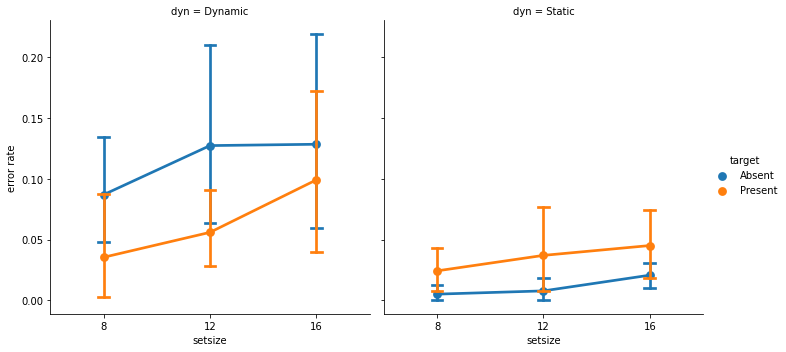

In [71]:
# visualize the error rate
sns.catplot(data = er_rates, x = 'setsize', 
            y = 'error rate',
            hue = 'target', col = 'dyn', kind = 'point', capsize = .1)

Your task:

* Please use `pingouin` to do a repeated measures ANOVA on error rates, separated for the 'static' and 'dynamic' displays.  


In [75]:
# your code here. 


### answer

In [76]:
pg.rm_anova(data = er_rates.query('dyn == "Dynamic"'), 
            dv = 'error rate', within = ['target','setsize'], subject = 'sub')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target,0.042356,1,10,0.042356,3.226369,0.102684,0.102684,0.243935,1.000000
1,setsize,0.030612,2,20,0.015306,4.297656,0.028012,0.038210,0.300585,0.814697
2,target * setsize,0.004866,2,20,0.002433,0.536065,0.593220,0.567841,0.050879,0.857452


In [77]:
pg.rm_anova(data = er_rates.query('dyn == "Static"'), 
            dv = 'error rate', within = ['target','setsize'], subject = 'sub')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target,0.009679,1,10,0.009679,4.303035,0.064806,0.064806,0.300848,1.000000
1,setsize,0.003671,2,20,0.001835,2.332876,0.122845,0.134766,0.189159,0.824210
2,target * setsize,0.000278,2,20,0.000139,0.169890,0.844963,0.741252,0.016705,0.622764


## Mean RTs

After we analyzed the error rates, we can now filter out those error trials, and move to mean RT analysis. 

__Note__, if you want to analyze inter-trial effect, you need to keep the whole raw data, and first identify what conditions of the previous trial before you remove those outliers and incorrect trials. 

In [80]:
# use the chain rule to quickly get the mean RTs
mrt = (dat_v.query('correct == 1')
      .groupby(['setsize','target','dyn','sub'])
      .rt.agg(['mean','sem'])
    ).reset_index()

mrt.head(5)

,setsize,target,dyn,sub,mean,sem
0,8,Absent,Dynamic,1,2.439717,0.131130
1,8,Absent,Dynamic,2,2.455142,0.135945
2,8,Absent,Dynamic,3,2.401525,0.125244
3,8,Absent,Dynamic,4,2.118680,0.104073
4,8,Absent,Dynamic,5,1.744670,0.190036


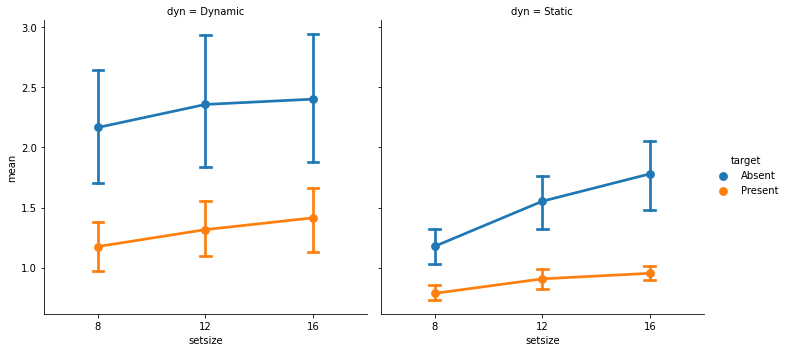

In [89]:
sns.catplot(data = mrt, x = 'setsize', y = 'mean',
            hue = 'target', col = 'dyn', kind = 'point', capsize = 0.1)

In [90]:
# let's test if the slopes were significant 
# between target absent and present, in two separate display types

pg.rm_anova(data = mrt.query("dyn == 'Static'"), 
            dv = 'mean',within = ['setsize', 'target'],
            subject = 'sub')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,setsize,1.675014,2,20,0.837507,53.411934,9.512398e-09,0.000002,0.842301,0.647841
1,target,6.382973,1,10,6.382973,45.130712,5.246409e-05,0.000052,0.818613,1.000000
2,setsize * target,0.527373,2,20,0.263686,22.691232,7.172774e-06,0.000238,0.694108,0.623721


There was a significant interaction, indicating the slopes were different for the target absent and present!

Let's take a look in the dynamic displays:

In [91]:
pg.rm_anova(data = mrt.query("dyn == 'Dynamic'"), 
            dv = 'mean',within = ['setsize', 'target'],
            subject = 'sub')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,setsize,0.653779,2,20,0.326890,15.266935,0.000094,0.000269,0.604226,0.846091
1,target,16.748926,1,10,16.748926,31.359654,0.000228,0.000228,0.758218,1.000000
2,setsize * target,0.010084,2,20,0.005042,0.546415,0.587424,0.586880,0.051810,0.996677


By contrast, the interaction in the dynamic display condition was not significant! In the paper, we did additional modeling and suggested that the 'flattened' slope in the target-absent condition was due to the early quiting process for the dynamic display. 

### RM-ANOVA via Statmodels

[statsmodels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. The package is released under the open source Modified BSD (3-clause) license. The online documentation is hosted at statsmodels.org.

Here we only mention one function `AnovaRM()`, which is very often used in within-subject design experiments. Currently, only fully balanced within-subject designs are supported. Calculation of between-subject effects and corrections for violation of sphericity are not yet implemented.

**Input Parameters**

* data: DataFrame
* depvar: The dependent variable in data
* subject: Specify the subject id
* within: The within-subject factors
* between: The between-subject factors, this is not yet implemented
* aggregate_func: {None, ‘mean’, callable}
If the data set contains more than a single observation per subject and cell of the specified model, this function will be used to aggregate the data before running the Anova. None (the default) will not perform any aggregation; ‘mean’ is s shortcut to numpy.mean. An exception will be raised if aggregation is required, but no aggregation function was specified.


In [92]:
# import the repeated measures ANOVA
from statsmodels.stats.anova import AnovaRM


In [93]:
aovrm = AnovaRM(mrt, 'mean','sub',within = ['setsize','target','dyn'])
res = aovrm.fit()
print(res)

                     Anova
                   F Value Num DF  Den DF Pr > F
------------------------------------------------
setsize            49.5463 2.0000 20.0000 0.0000
target             41.6282 1.0000 10.0000 0.0001
dyn                17.4956 1.0000 10.0000 0.0019
setsize:target     13.8575 2.0000 20.0000 0.0002
setsize:dyn         4.0524 2.0000 20.0000 0.0333
target:dyn          8.2135 1.0000 10.0000 0.0168
setsize:target:dyn 12.0286 2.0000 20.0000 0.0004



## Speed-accuracy trade-off

So far we conduct analyses on error rates and RTs separated. In the course, we reviewed several methods to combine error rates and RTs together. One common method is the inverse efficiency score (IES):

$$IES = \frac {RT}{1-PC}$$

There are other methods. One important feature of IES is that it remains the same unit as the RT (in ms or secs). 

Let's practice on this with the above example. We have already calcualted error rates (`er_rates`) and mean RTs (`mrt`). 

Steps:
1. merge two tables
2. calculate IES
3. do further visualization and statistics

In [94]:
#lets first check the two tables. 
er_rates.head(3)

,sub,dyn,setsize,target,error rate
0,1,Dynamic,8,Absent,0.000000
1,1,Dynamic,8,Present,0.030303
2,1,Dynamic,12,Absent,0.031250


In [95]:
mrt.head(3)

,setsize,target,dyn,sub,mean,sem
0,8,Absent,Dynamic,1,2.439717,0.131130
1,8,Absent,Dynamic,2,2.455142,0.135945
2,8,Absent,Dynamic,3,2.401525,0.125244


In [99]:
# merge two tables
comb_means = pd.merge(mrt, er_rates, on = ['sub','dyn','setsize','target'])
comb_means['ies'] = comb_means['mean']/(1-comb_means['error rate'])
comb_means.head()

,setsize,target,dyn,sub,mean,sem,error rate,ies
0,8,Absent,Dynamic,1,2.439717,0.131130,0.000000,2.439717
1,8,Absent,Dynamic,2,2.455142,0.135945,0.088235,2.692736
2,8,Absent,Dynamic,3,2.401525,0.125244,0.000000,2.401525
3,8,Absent,Dynamic,4,2.118680,0.104073,0.028571,2.180994
4,8,Absent,Dynamic,5,1.744670,0.190036,0.281250,2.427367


Pleas compare the original mean rt and ies in the rows 0 and 4!

__Warning__:

Note, IES transformation should be use cautiously and make sure the error rates are within 10%. In this case, the error rate for subject '5' was 28.1%. So basically you shouldn't use this tranform. As we can see from the above, due to high error rates, the transformed IES was changed from original RT about 30% (from 1.74 secs to 2.43 secs, 700 ms more!). 


### Your homework

Please do other SAT transforms using similar codes that I illustrated above. 
